In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, hinge_loss
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

### Patient level prediciton
<!-- We used following tables : 
- kdigo_stages
- elixhauser_score_ahrq
- elixhauser_score_quan
- prescription (optional)
- First Day Measurmenets
  - blood_gas_firstday
  - gcs_first_day
  - labs_first_day
  - urine_output_first_day
  - ventilation_first_day
  - vitals_first_day
  - weight_first_day
- every_score
- explicit
- martin
- icustay_detail_age -->

In [50]:
df = pd.read_csv("./../data/datasetFpmIcuStayDetail.csv")

In [51]:
df.drop_duplicates(subset="icustay_id")

,icustay_id,age,pulmonary,pao2fio2,mingcs,heartrate_mean,wbc_min,wbc_max,sysbp_mean,urineoutput,...,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,first_icu_stay,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30
0,205907,50.645076,3,NaN,15.0,114.774194,32.1,36.1,138.966667,5.0,...,1,t,2161-07-31 17:00:41,2161-08-12 16:50:22,11.9928,1,t,12.0,18.0,20.0
1,216788,60.761024,0,NaN,15.0,92.071429,7.4,7.4,100.489362,1500.0,...,1,t,2177-01-01 11:28:00,2177-01-05 11:34:00,4.0042,1,t,0.0,-1.0,6.0
2,211038,64.889926,0,NaN,15.0,89.371429,10.0,10.0,103.228571,1766.0,...,1,t,2147-11-10 12:38:00,2147-11-12 17:44:00,2.2125,1,t,0.0,-2.0,-2.0
3,200728,56.996581,0,NaN,14.0,88.189189,9.5,18.8,154.365854,2135.0,...,1,t,2151-01-04 13:05:15,2151-01-06 14:59:35,2.0794,1,t,7.0,8.0,17.0
4,202996,64.887600,3,128.571429,15.0,89.310345,7.3,13.3,143.606061,2700.0,...,1,t,2139-10-05 16:14:41,2139-10-27 15:36:18,21.9733,1,t,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108271,282141,52.750732,0,NaN,14.0,84.269231,3.7,8.0,117.166667,4225.0,...,1,t,2121-01-28 18:47:24,2121-01-30 21:01:09,2.0929,1,t,3.0,6.0,6.0
108305,269434,64.819398,0,NaN,8.0,107.321429,15.0,18.0,159.321429,2740.0,...,1,t,2135-03-26 18:24:01,2135-03-28 20:32:04,2.0889,1,t,2.0,3.0,6.0
108316,271929,71.148891,0,NaN,13.0,108.500000,18.1,18.1,106.318182,2380.0,...,2,f,2128-06-16 13:31:08,2128-06-22 21:47:12,6.3445,1,t,11.0,3.0,7.0
108337,273416,71.486196,0,NaN,14.0,79.826087,15.3,19.4,144.904762,2550.0,...,1,t,2121-08-20 18:16:12,2121-08-22 18:22:00,2.0040,1,t,4.0,5.0,4.0


In [52]:
df = df[(df['age'] > 18) & (df['age'] < 89)]

In [53]:
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.5]]
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

List of dropped columns: dod, 



#### XGBoost

In [54]:
for colName, colType in zip(df.columns, df.dtypes):
    if(colType == "object"):
        df[colName] = df[colName].astype('category')
        df[colName] = df[colName].cat.codes
df.dtypes

icustay_id                  int64
age                       float64
pulmonary                   int64
pao2fio2                  float64
mingcs                    float64
heartrate_mean            float64
wbc_min                   float64
wbc_max                   float64
sysbp_mean                float64
urineoutput               float64
pco2                      float64
po2                         int64
icu_level                   int64
subject_id                  int64
hadm_id                     int64
gender                       int8
admittime                   int16
dischtime                   int16
los_hospital              float64
ethnicity                    int8
ethnicity_grouped            int8
admission_type               int8
hospital_expire_flag        int64
hospstay_seq                int64
first_hosp_stay              int8
intime                      int16
outtime                     int16
los_icu                   float64
icustay_seq                 int64
first_icu_stay

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, ~df.columns.isin(["icu_level"])], df["icu_level"], test_size=0.33, random_state=42)

In [56]:
train = xgb.DMatrix(X_train,label=y_train)
test  = xgb.DMatrix(X_test,label=y_test)

In [57]:
epochs = 10
param = {
    'eta':0.9,
    'objective': 'multi:softmax',
    'num_class': 4
}

In [58]:
model = xgb.train(param, train, epochs)

In [59]:
pred = model.predict(test)
pred = pd.DataFrame(pred)
acc = accuracy_score(y_test,pred)
for col in pred:
    print(pred[col].unique())

[2. 1. 3.]


In [60]:
print("Model Accuracy : {}".format(acc))
print(y_train.value_counts())

Model Accuracy : 0.8919145605010065
1    47299
2    18379
3     6941
Name: icu_level, dtype: int64


#### Support Vector Machine

In [61]:
print("For SVM removing all columns that have at least one NULL value ... ")
df = df.dropna(how='any',axis=0) 

For SVM removing all columns that have at least one NULL value ... 


In [62]:
x = df.loc[:, ~df.columns.isin(["icu_level"])].values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_train = pd.DataFrame(x_scaled)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df["icu_level"], test_size=0.33, random_state=42)

In [64]:
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [65]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.769708698309228


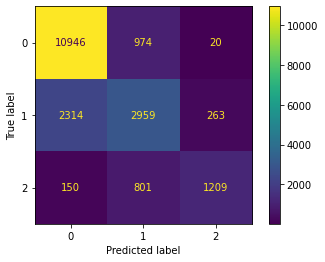

In [69]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()